In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib
from scipy.optimize import curve_fit
from statsmodels.tsa import arima_model

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')
pd.set_option('display.max_rows', 500)

def extrapolate(df=None, func=None, guess=None):
    """add exprapolation function, since Pandas does not have that ability"""
    
    # Convert to DataFrame, if needed
    if isinstance(df, pd.Series):
        df = pd.DataFrame(df)

    # Temporarily remove dates and make index numeric
    di = df.index
    if isinstance(df.columns, pd.core.index.MultiIndex):
        df = df.reset_index().drop(di.name, axis=1, level=0)
    else:
        df = df.reset_index().drop(di.name, axis=1)

    # Place to store function parameters for each column
    col_params = {}

    # Curve fit each column
    for col in df.columns:
        # Create copy of data to remove NaNs for curve fitting
        fit_df = df[[col]].dropna()
        # Get x & y
        x = fit_df.index.astype(float).values
        y = fit_df[col].astype(float).values
        # Curve fit column and get curve parameters
        if len(x) > 0 and len(y) > 0:
            params = curve_fit(func, x, y, guess, maxfev=10000)
            # Store optimized parameters
            col_params[col] = params[0]
        
    # Extrapolate each column
    for col in df.columns:
        if col in col_params:
            # Get the index values for NaNs in the column
            x = df[pd.isnull(df[col])].index.astype(float).values
            # Extrapolate those points with the fitted function
            df[col][x] = func(x, *col_params[col])

    # Put date index back
    df.index = di
    
    # Put DataFrame back to Series if necessary
    df = df.squeeze()

    return (df, col_params)


In [2]:
def arima_extrapolation(df, **kwds):
    """ Extrapolate DataFrame with ARIMA method """

    # Local Constants
    ARIMA_ORDERS = [(3, 2, 1), (2, 2, 1), (2, 1, 1), (1, 1, 1), (1, 1, 0), (1, 0, 0)]

    # Convert to DataFrame, if needed
    if isinstance(df, pd.Series):
        df = pd.DataFrame(df)

    # Copy to not overwrite
    df_c = df.copy()

    # Determine times
    start = df.index[0]
    end = df.index[-1]
    dates = pd.date_range(start, end, freq='MS')

    # Extrapolate each column
    for col, data in df_c.iteritems():
        
        # Remove NaNs from model training data
        data = data.dropna()
        
        if (len(data) > 0):
            
            # ARIMA does not like tuple names
            if isinstance(data.name, tuple):
                data.name = '_'.join(list(data.name))

            na_start = data.index[0]
            na_end = data.index[-1]

            # ARIMA model order is unknown, so find the highest order that can be fit
            order = 0
            modeled = False
            while not modeled and order < len(ARIMA_ORDERS):
                try:
                    model = arima_model.ARIMA(data, order=ARIMA_ORDERS[order])
                    results = model.fit()
                    extrapolation = results.predict(
                        start=str(na_end.to_datetime()), 
                        end=str(end.to_datetime()), 
                        typ='levels'
                    )
                    modeled = True
                except:
                    order += 1

            if not modeled:
                extrapolation = pd.Series(np.nan, index=dates)

            # Get the index values for NaNs in the column
            x = df[pd.isnull(df[col])].index
                        
            # Add extrapolated values
            df[col][x] = extrapolation[x]

    # Put DataFrame back to Series if necessary
    df = df.squeeze()
    
    return df



In [3]:
# FRED download: https://research.stlouisfed.org/fred2/downloaddata/
# Import FRED look up csv
fred_path = '~/Dropbox/FRED2_csv_2/'
fred = pd.read_csv(
    fred_path + 'README_TITLE_SORT.txt', 
    skiprows=9, 
    skipfooter=22, 
    sep=';',
    parse_dates=[5],
    skipinitialspace=True,
    engine='python'
)
fred.columns = fred.columns.str.strip()
# Remove all "(DISCONTINUED)" rows
fred = fred[~fred['Title'].str.contains('DISCONTINUED')]
fred = fred.set_index('Title')


In [4]:
# Get all U.S. population data
uspop = fred[fred.index.str.match('Population.*United States.*')]
# Remove % change units
uspop = uspop[~uspop['Units'].str.contains('%')]
# Find the latest
uspop = uspop.loc[uspop['Last Updated'].argmax()].iloc[0]
uspop
# Readin population data
uspop_data = pd.read_csv(
        fred_path + 'data/' + uspop['File'].strip().replace('\\', '/'), 
        index_col='DATE',
        parse_dates=True
    )['VALUE']


In [5]:
# Get all personal income/exspense data
personal = fred[fred.index.str.match('Personal.*')]

# Remove State based data
personal = personal[~personal.index.str.contains('.*, [A-Z]{2}')]
personal = personal[~personal.index.str.contains('.*for Social Insurance in.*')]
personal = personal[~personal.index.str.contains('.*District of Columbia.*')]

# Remove per capitas
personal = personal[~personal.index.str.contains('.*per capita.*')]

# Remove old 2012 style data
personal = personal[~personal.index.str.contains('.*for United States')]

# Remove nonresidents
personal = personal[~personal.index.str.contains('.*nonresidents.*')]

# Remove % change and index units
personal = personal[~personal['Units'].str.contains('%|Index|Persons|National Currency')]

# Get only monthly, quartarly or yearly data
personal = personal[personal['Frequency'].str.contains('M|Q|A')]

# Remap frequency to number of months
personal['Frequency'].replace({'M': 1, 'Q': 3, 'A': 12}, inplace=True)

# Remap text units to numbers
personal['Units'].replace({'Bil. of $': 1e9, 'Mil. of $': 1e6, 'Bil. Of $': 1e9}, inplace=True)
    
# Keep only the highest resolution of duplicate data
personal = personal.reset_index() \
    .sort_values(['Title', 'Frequency', 'Last Updated'], ascending=[1, 1, 0]) \
    .drop_duplicates(subset='Title', keep='first') \
    .sort_values('Title').set_index('Title')


In [6]:
# Convert to hierarchal index by spliting on ':'
personal.index = pd.MultiIndex.from_arrays(
    pd.DataFrame.from_dict({
        k: v for k, v in enumerate(personal.index.str.split(':', 3))
    }, orient='index').T.values
)
# Transpose data for ease of next code
personal = personal.T
# Replace empty levels of heirarchy with string and remove whitespace
personal.columns = pd.MultiIndex.from_arrays(
    np.array([
        [x.strip() if not pd.isnull(x) else 'Total' 
            for x in col] 
                for col in personal.columns.tolist()
        ]).T
    )


In [7]:
# Create empty frame for data based on personal categories
personal_data = pd.DataFrame(columns=personal.columns)

# Read in each category of data
for i, (category, filename) in enumerate(personal.loc['File'].iteritems()):
    data = pd.read_csv(
        fred_path + 'data/' + filename.strip().replace('\\', '/'), 
        index_col='DATE',
        parse_dates=True
    )
    personal_data[category] = data['VALUE']

# Fill NaNs with interpolated data
personal_data.interpolate(method='polynomial', order=5, limit_direction='both', inplace=True)

# Find first date of valid data
first_date = pd.DatetimeIndex([pd.datetime(1900,1,1)])[0]
for col, data in personal_data.iteritems():
    first_col_date = data.first_valid_index()
    if first_col_date:
        first_date = max(first_date, first_col_date)

# Chop off data before 1980
personal_data = personal_data[first_date:]

# Function to curve fit to the data
def exp_param(x, a, b):
    return a * np.exp(-b * x)
# Initial parameter guess, just to kick off the optimization
exp_guess = (1, 1e-6)

# Fill leading and trailing NaNs with extrapolated data
# personal_data, models = extrapolate(personal_data, exp_param, exp_guess)
personal_data = arima_extrapolation(personal_data)

# Normalize data to base units
personal_data = personal_data.mul(personal.loc['Units'], axis=1)


/Users/timothydavenport/anaconda/lib/python2.7/site-packages/statsmodels/base/data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)
/Users/timothydavenport/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/timothydavenport/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/timothydavenport/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/timothydavenport/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum L

In [8]:
# Sample U.S. population to the other data's dates
uspop_data = pd.Series(uspop_data, index=personal_data.index)

# Chop off data before 1980
uspop_data = uspop_data['1980':]

# Fill NaNs with interpolated data
uspop_data.interpolate(method='polynomial', order=5, limit_direction='both', inplace=True)

# Function to curve fit to the data
def lin_param(x, m, b):
    return m * x + b
# Initial parameter guess, just to kick off the optimization
lin_guess = (1, 1)

# Fill leading and trailing NaNs with extrapolated data
# uspop_data, popmodel = extrapolate(uspop_data, lin_param, lin_guess)
uspop_data = arima_extrapolation(uspop_data)


In [9]:
# Calculate the average data per person by dividing each category per person
average_data = personal_data.divide(uspop_data, axis=0)


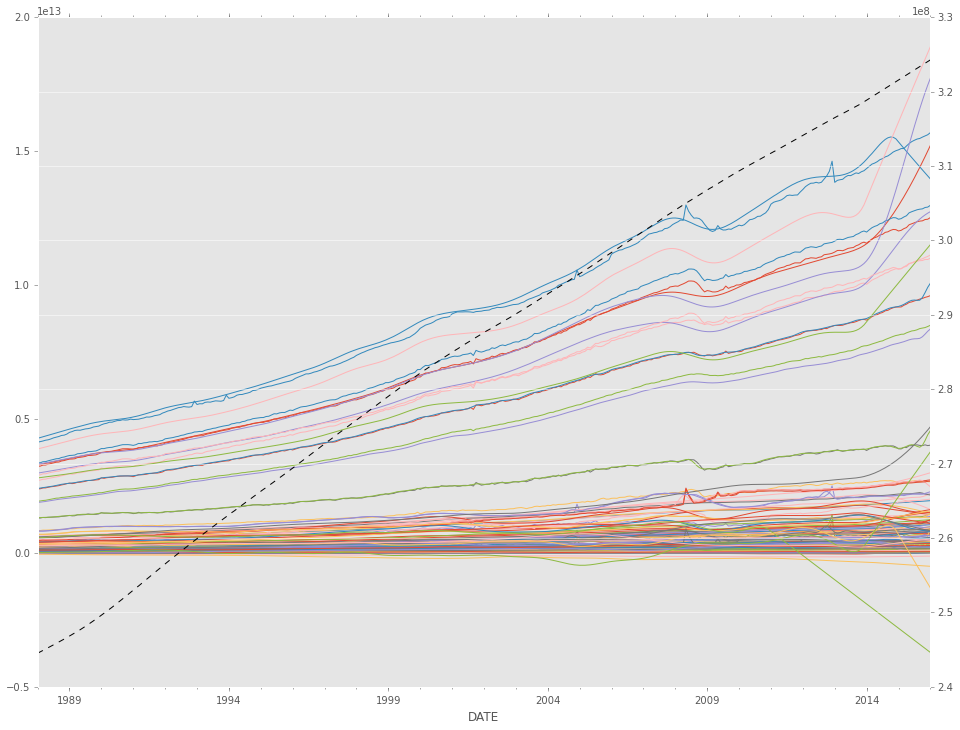

In [10]:
# Plot to check proper import
personal_data.plot(legend=False)
uspop_data.plot(legend=False, style='k--', secondary_y=True)


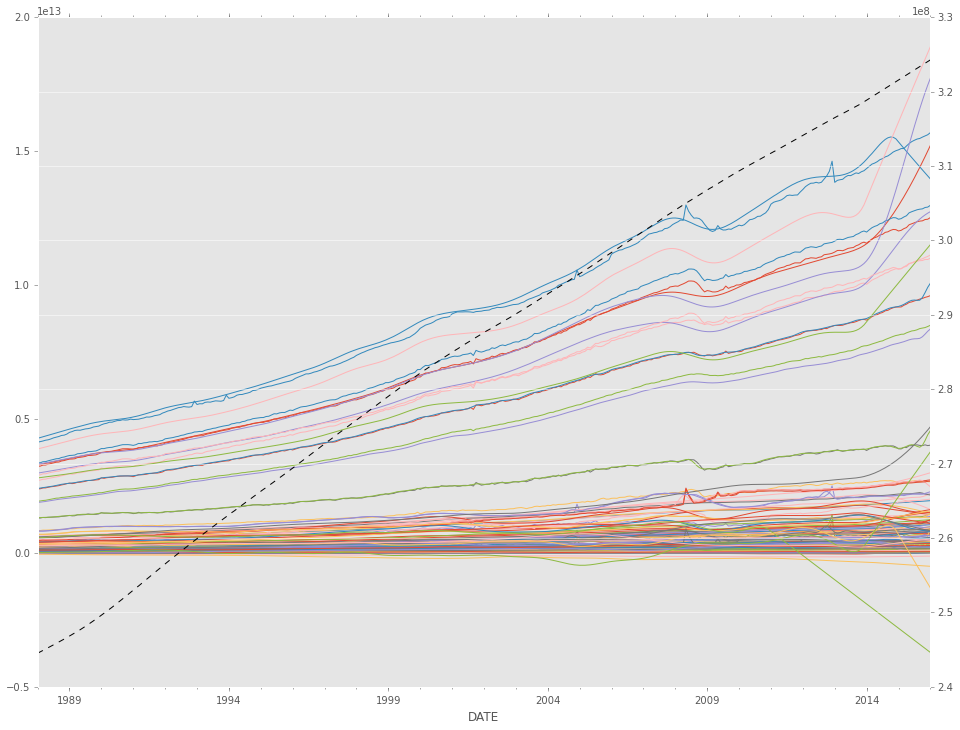

In [11]:
# Plot to check proper import
personal_data.plot(legend=False)
uspop_data.plot(legend=False, style='k--', secondary_y=True)


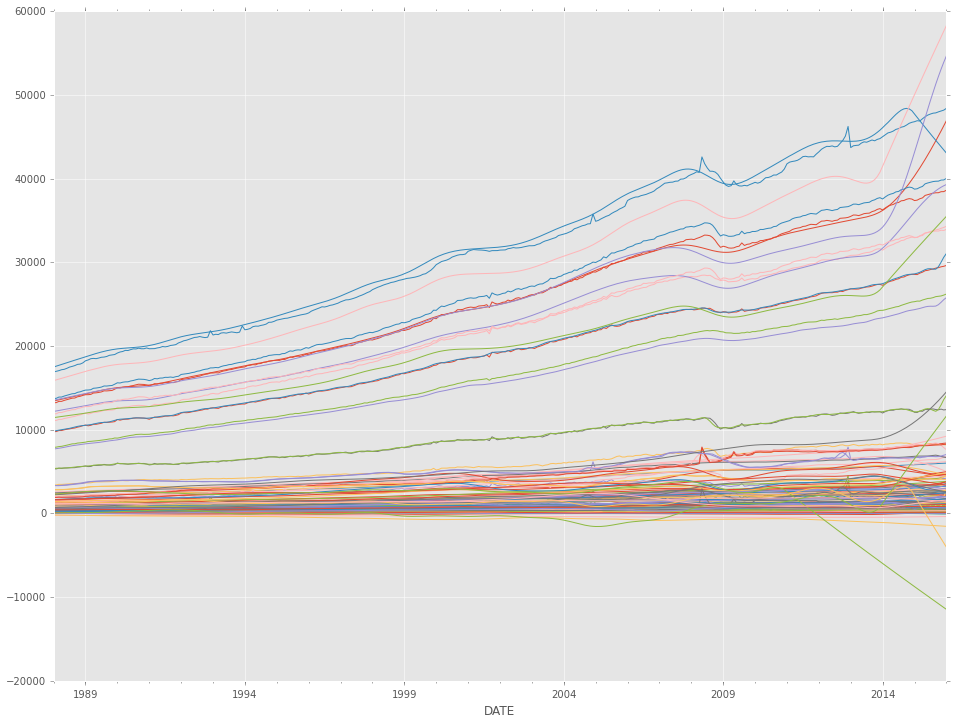

In [12]:
# Plot average to check proper import
average_data.plot(legend=False)

In [13]:
# Collapse the heiarchy of categories to the last non Total level
categories = ['' for x in xrange(len(average_data.columns))]
for level in xrange(len(average_data.columns.levels)-1, -1, -1):
    for i, cat in enumerate(average_data.columns.get_level_values(level)):
        if cat != 'Total' and categories[i] == '':
            categories[i] = cat

# Replace multi index with collapsed categories
average_data.columns = categories


In [14]:
for col in average_data.columns:
    print col


Personal Consumption Expenditures
Housing
Durable Goods
Goods
Nondurable Goods
Services
Property Taxes
Personal Current Transfer Receipts
Personal Income
Personal Income Receipts on Assets
Personal Dividend Income
Personal Interest Income
Personal Saving
Personal consumption expenditures excluding food and energy
Accounting and other business services
Admissions to specified spectator amusements
Live entertainment, excluding sports
Motion picture theaters
Spectator sports
Amusements parks, campgrounds, and related recreational services
Cleaning, repair, and rental of clothing
Clothing
Clothing repair, rental, and alterations
Clothing, footwear, and related services
Other clothing materials
Communication
First-class postal service by U.S. Postal Service (USPS)
Educational books
Furnishings and durable household equipment
Furniture and furnishings
Glassware, tableware, and household utensils
Household appliances
Jewelry and watches
Luggage and similar personal items
Motor vehicle parts a

In [15]:
# Write out to pickle
average_data.to_csv('average_personal_income_and_expense.csv')
